In [1]:
import matplotlib.pyplot as plt
import astropy.io.fits as ast
import numpy as np
import csv

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename 

from photutils import centroid_com

print("Required Libraries Loaded Successfully...")

%matplotlib inline
plt.ion()
print("Matplotlib Intialised...")

import tools
print("Imported Oliver King's Planetary Science Tools Successfully...")

def AU_to_km(n):
    Dist = n*149598000
    return Dist
print("Defined all Necessary Unit Conversion Routines...")

print("\nAll Modules Imported Successfully!")

Required Libraries Loaded Successfully...
Matplotlib Intialised...
Imported Oliver King's Planetary Science Tools Successfully...
Defined all Necessary Unit Conversion Routines...

All Modules Imported Successfully!


# Reading In An Image

This following cell deals with the reading in of the image datafiles from the MAST archive, and filtering out the outlying datapoints. The filter pass boundaries are 0 <= data <= 100, as this filters out any abnormally bright pixels in the image, that could potentially hide the disc in the contrast. This code also reads from the headers to find the times that the image was taken (in order to look up ephemerides on JPL horizons) and the PHOTFLAM to then calculate the I/F calibration factor for that image, and then apply the factor to that image data. 

In [2]:
#initialises the crucial variables
filepath = "OPAL RAWS/Cycle_26/1/"
filters = ['F467M','F547M','FQ619N','F657N','FQ727N','F763M','F845M']
wavelength = ['467','547','619','657','727','763','845']
SolFlux = [2019.04,1859.82,1707.85,1238,1339.23,1541.91,1023.5] #Solar Flux in each filter wavelengths according to Amy Simon's Spreadsheet 
IF_Factors_OPAL = [0.00475,0.00249,0.00160,0.00405,0.00203,0.00145,0.00130] #taken from the OPAL ReadMe
fitsdata = ['','','','','','','']
resolution = ['','','','','','','']
imgdata = ['','','','','','','']
fitshdr = ['','','','','','','']
scihdr = ['','','','','','','']
ephemerides = ['','','','','','','']
CLEANUPFLAG = False

for i in range(len(filters)):
    file = get_pkg_data_filename(filepath+filters[i]+'/'+wavelength[i]+'_1_drz.fits')
    fitsdata[i] = fits.open(file)
    imgdata[i] = fits.getdata(file, ext=1)
    resolution[i] = imgdata[i].shape
    fitshdr[i] = fitsdata[i][0].header
    scihdr[i] = fitsdata[i][1].header
    #899 = Neptune Moving Target
    #@hst = Hubble Space Telescope
    #reads epoch from header[exposure start time]
    ephemerides[i] = tools.mapping.get_ephemerides(target = 'neptune', loc = 'hst', epoch = fitshdr[i]['EXPSTART']) 
    
print('Image Read Successfully, move on to next cell')

Image Read Successfully, move on to next cell


# Data Calibration
The following cell takes the data that was read in above, and then calculates the I/F calibration factor for the data. The formula to calculate the I/F factor is (Excel Formula):

(PHOTFLAMx10/SOLID ANGLE OF A PIXEL (steradians))/((1AU/SUN DIST)^2xSOLAR FLUX/PI)

This routine currently gives error results, as I do not understand the solar flux quantity. Is it solar flux at neptune? at earth? at the sun's surface? It appears to have a wavelength dependance, why? 

In [11]:
#Defines the constants needed to calculate I/F conversion factor that are based on the WFC3/UVIS Instrument
#PixWidth = plate scale of WFC3/UVIS, taken from Amy Simon's Uranus Spreadsheet, and checked with the WFC3 Manual
PixWidth = 0.04 #arcseconds 
#omega = Solid Angle of a Single WFC3/UVIS Pixel
omega = ((PixWidth/3600)*(np.pi/180))**2 #steradians
dist = AU_to_km(ephemerides[0]['r'])
PHOTFLAM = 4.5375e-19
Flux = 1023.65


#initialises the array of I/F factors for the imported imageset
IF_Factors = np.zeros(len(filters))

#determines I/F factors with the above formula for each image in the set
for i in range(len(filters)):
    fractop = ((PHOTFLAM*10)/omega)
    fracbottom = ((AU_to_km(1.0)/AU_to_km(dist))**2)*(SolFlux[i]/np.pi)
    IF_Factors[i] = fractop/fracbottom
    
print(IF_Factors)

print(IF_Factors_OPAL)

print(PHOTFLAM)

print(omega)

print(SolFlux)

#Applies the I/F Factors to the data products of the image, as my calculation is wrong code uses values from OPAL Readme
for i in range(len(filters)):
    imgdata[i] = imgdata[i]*IF_Factors_OPAL[i]
    
print('Image Calibrated using OPAL I/F Factors')

[3.76481872e+12 4.08712649e+12 4.45081219e+12 6.13999967e+12
 5.67588808e+12 4.92980757e+12 7.42679003e+12]
[0.00475, 0.00249, 0.0016, 0.00405, 0.00203, 0.00145, 0.0013]
4.5375e-19
3.7607088862556617e-14
[2019.04, 1859.82, 1707.85, 1238, 1339.23, 1541.91, 1023.5]
Image Calibrated using OPAL I/F Factors


# Image Navigation

The following code cell navigates the image. 
Navigating the image includes:-
- Filtering out extreme pixels
- Finding the Disc in the image
- Finding the Planicentre
- Writes the Planicentre to a file called YEAR_Planicentres

(259.80149019071706, 269.19266525394767, 40.0)
(260.34082688212027, 268.1009769784659, 40.0)


C:\Users\jamie\Documents\Uni Work\Year 4\PA4900 Specialist Research Project\CODE AHHHHHHH\Neptune from Scratch\IMAGE MAPPING\tools\mapping.py:331: RuntimeWarning: invalid value encountered in sqrt
  z_img = np.sqrt(1 - x_img**2 - y_img**2)


(1047.9486867196251, 1044.4218531367926, 40.0)
(259.87707055214725, 269.0550996932515, 40.0)
(1094.3086674577255, 1148.5324976977126, 40.0)
(260.36112659431456, 266.75822158103546, 40.0)
(261.1596491795851, 267.2926955564905, 40.0)


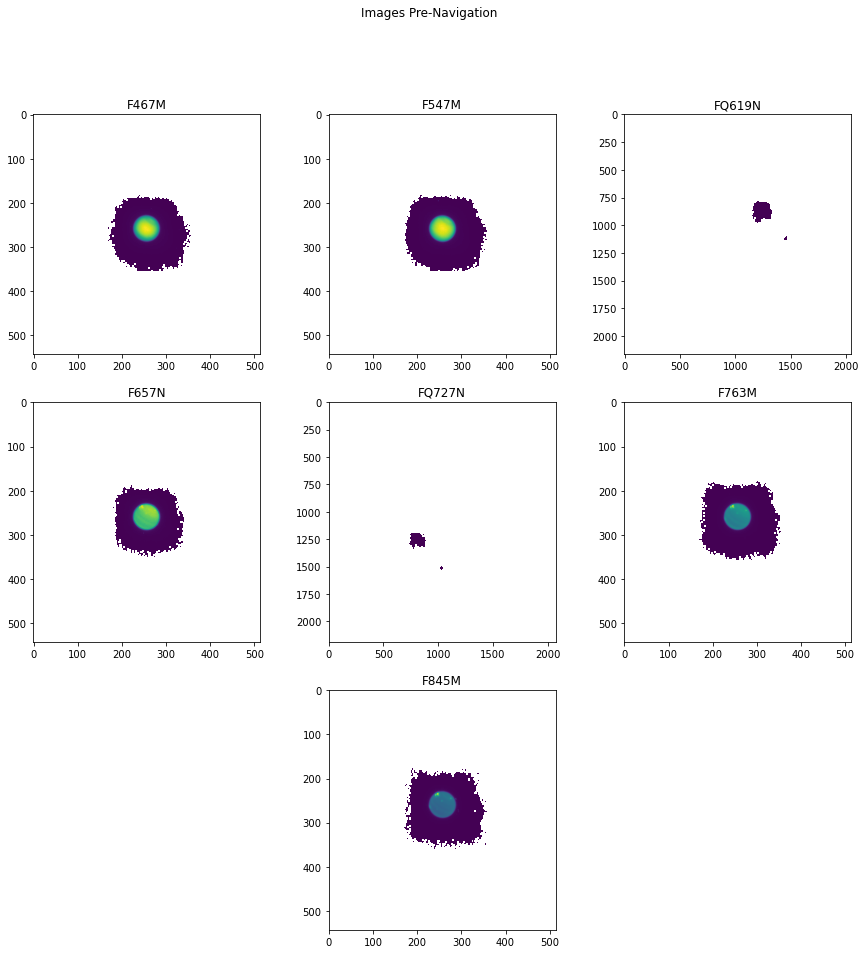

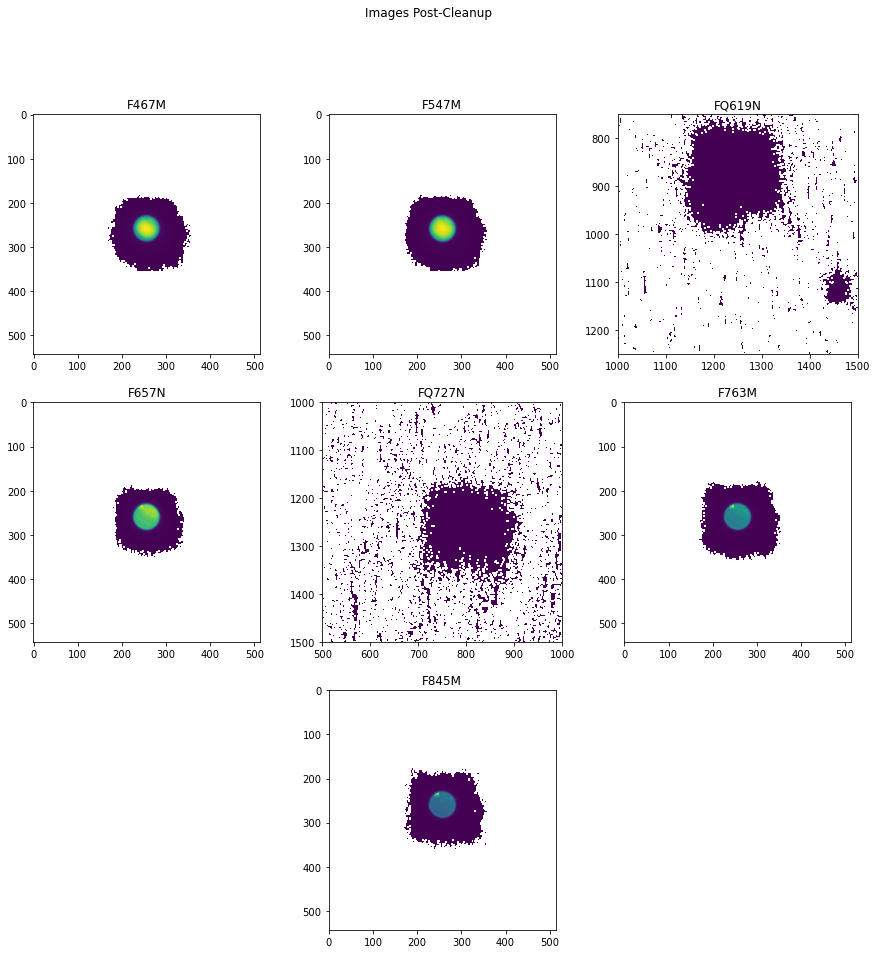

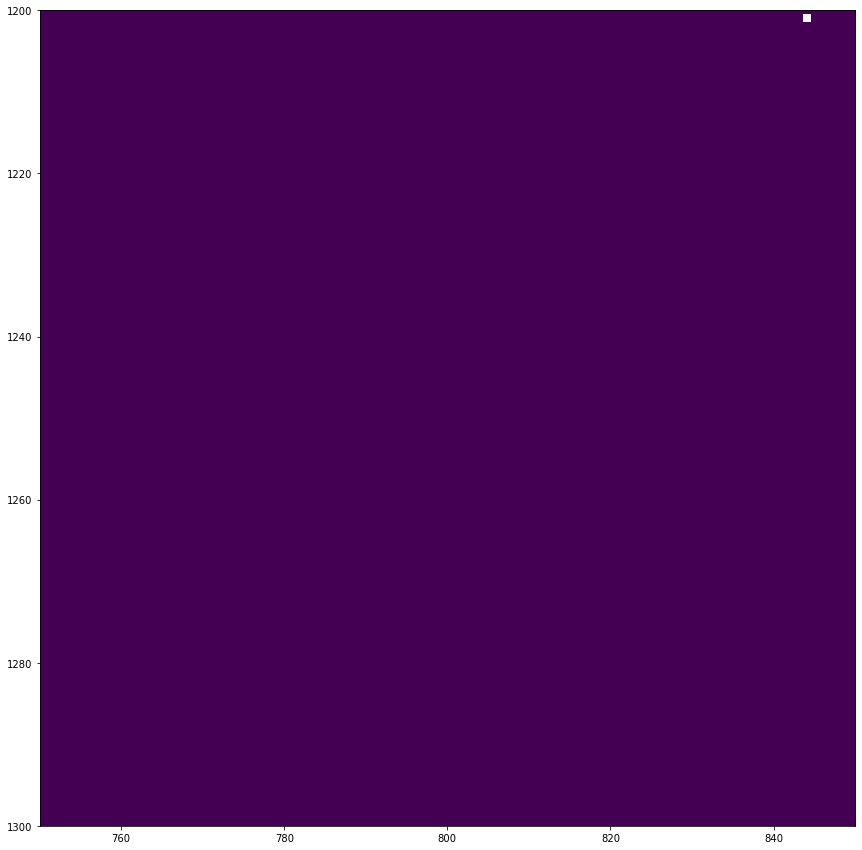

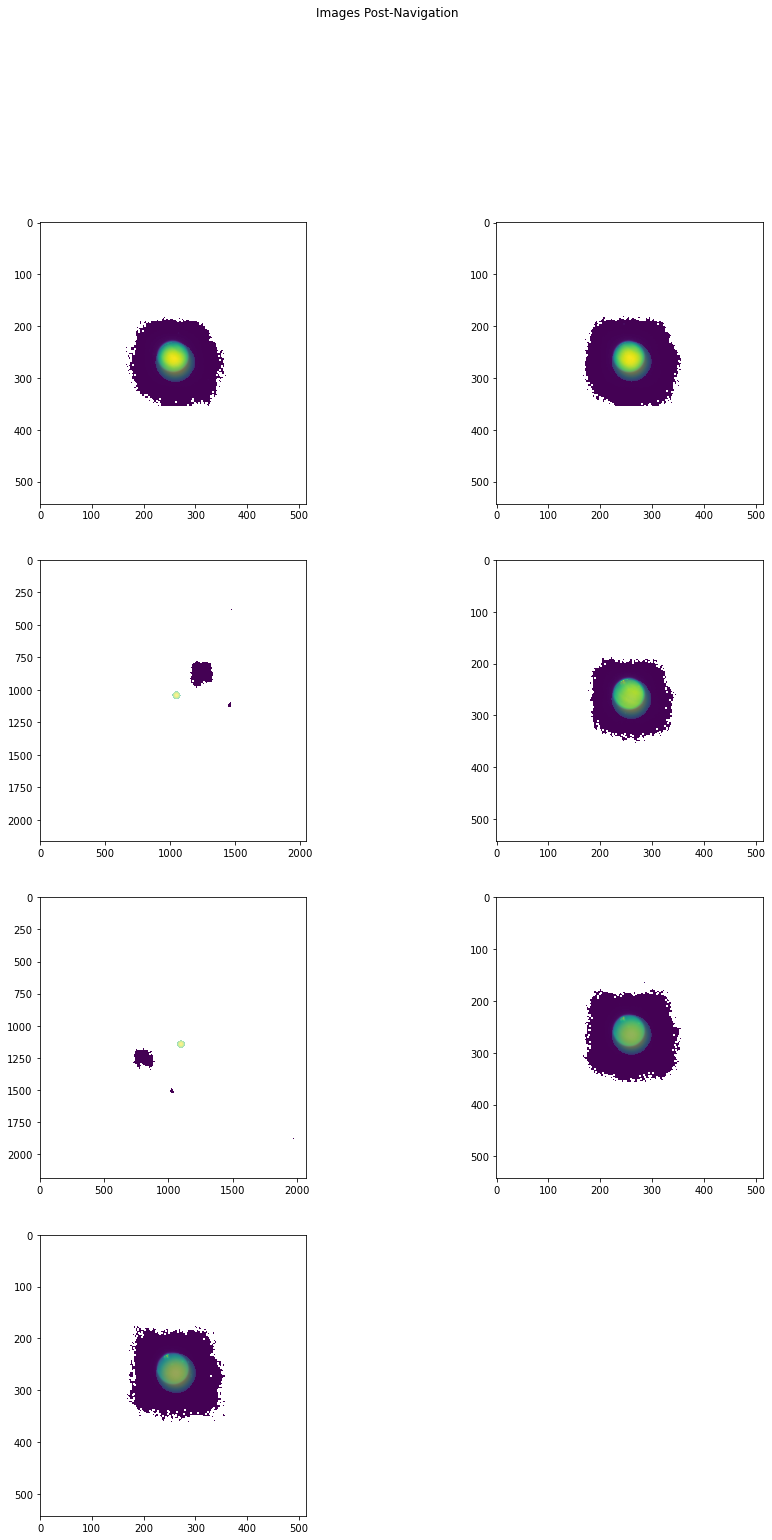

In [5]:
planicentre = ['','','','','','','']
masks = ['','','','','','','']
xyz = ['','','','','','','']
longlat = ['','','','','','','']
map_obj = ['','','','','','','']

plt.figure(figsize=(15,15))
plt.suptitle('Images Pre-Navigation')
ax1 = plt.subplot(331)
ax1.imshow(imgdata[0])
plt.title(filters[0])
ax2 = plt.subplot(332)
ax2.imshow(imgdata[1])
plt.title(filters[1])
ax3 = plt.subplot(333)
ax3.imshow(imgdata[2])
plt.title(filters[2])
ax4 = plt.subplot(334)
ax4.imshow(imgdata[3])
plt.title(filters[3])
ax5 = plt.subplot(335)
ax5.imshow(imgdata[4])
plt.title(filters[4])
ax6 = plt.subplot(336)
ax6.imshow(imgdata[5])
plt.title(filters[5])
ax7 = plt.subplot(338)
ax7.imshow(imgdata[6])
plt.title(filters[6])

if CLEANUPFLAG == False:
    CLEANUPFLAG = True
    for k in range(len(filters)):
        if (k==2)or(k==4):
            for i in range(resolution[k][0]):
                for j in range(resolution[k][1]):
                    if imgdata[k][i][j] < 0:
                        imgdata[k][i][j] = np.nan
                    if imgdata[k][i][j] > 10:
                        imgdata[k][i][j] = np.nan
            planicentre1 = centroid_com(imgdata[k])
            print(planicentre1)
        else:
            for i in range(resolution[k][0]):
                for j in range(resolution[k][1]):
                    if imgdata[k][i][j] < 0:
                        imgdata[k][i][j] = np.nan
            planicentre1 = centroid_com(imgdata[k])
            print(planicentre1)
            for i in range(resolution[k][0]):
                for j in range(resolution[k][1]):
                    if i not in range(int(planicentre1[0])-100, int(planicentre1[0])+100):
                        imgdata[k][i][j] = np.nan
                    if j not in range(int(planicentre1[1])-100, int(planicentre1[1])+100):
                        imgdata[k][i][j] = np.nan  

    #for k in range(len(filters)):
    #    for i in range(resolution[k][0]):
    #        for j in range(resolution[k][1]):
    #            if imgdata[k][i][j] < 0:
    #                imgdata[k][i][j] = np.nan       

    #    for i in range(resolution[k][0]):
    #        for j in range(resolution[k][1]):
    #            if i not in range(int(planicentre1[0])-100, int(planicentre1[0])+100):
    #                imgdata[k][i][j] = np.nan
    #            if j not in range(int(planicentre1[1])-100, int(planicentre1[1])+100):
    #                imgdata[k][i][j] = np.nan

    #for i in range(len(filters)):
    #    imgdata[i] = tools.image.sigma_filter(imgdata[i])
    
#plots images post cleanup
plt.figure(figsize=(15,15))
plt.suptitle('Images Post-Cleanup')
ax1 = plt.subplot(331)
ax1.imshow(imgdata[0])
plt.title(filters[0])
ax2 = plt.subplot(332)
ax2.imshow(imgdata[1])
plt.title(filters[1])
ax3 = plt.subplot(333)
ax3.imshow(imgdata[2])
plt.title(filters[2])
plt.xlim(1000,1500)
plt.ylim(1250,750)
ax4 = plt.subplot(334)
ax4.imshow(imgdata[3])
plt.title(filters[3])
ax5 = plt.subplot(335)
ax5.imshow(imgdata[4])
plt.title(filters[4])
plt.xlim(500,1000)
plt.ylim(1500,1000)
ax6 = plt.subplot(336)
ax6.imshow(imgdata[5])
plt.title(filters[5])
ax7 = plt.subplot(338)
ax7.imshow(imgdata[6])
plt.title(filters[6])
 
plt.figure(figsize=(15,15))
plt.imshow(imgdata[4])
plt.xlim(750,850)
plt.ylim(1300,1200)
    
for i in range(len(filters)):
    planicentre[i] = tools.mapping.get_disc(imgdata[i], r0=40)
    print(planicentre[i])
    xyz[i] = tools.mapping.img_to_xyz(resolution[i],planicentre[i][0],planicentre[i][1],planicentre[i][2])
    #longlat[i] = tools.mapping.img_to_longlat(resolution[i],planicentre[i][0],planicentre[i][1],planicentre[i][2],
    #                                          ephemerides[i]['NPole_ang'],ephemerides[i]['PDObsLon'],ephemerides[i]['PDObsLat'])

plt.figure(figsize=(15,30))
plt.suptitle('Images Post-Navigation')
ax1 = plt.subplot(521)
ax1.imshow(imgdata[0])
ax1.imshow(xyz[0][2], alpha=0.5)
ax2 = plt.subplot(522)
ax2.imshow(imgdata[1])
ax2.imshow(xyz[1][2], alpha=0.5)
ax3 = plt.subplot(523)
ax3.imshow(imgdata[2])
ax3.imshow(xyz[2][2], alpha=0.5)
ax4 = plt.subplot(524)
ax4.imshow(imgdata[3])
ax4.imshow(xyz[3][2], alpha=0.5)
ax5 = plt.subplot(525)
ax5.imshow(imgdata[4])
ax5.imshow(xyz[4][2], alpha=0.5)
ax6 = plt.subplot(526)
ax6.imshow(imgdata[5])
ax6.imshow(xyz[5][2], alpha=0.5)
ax7 = plt.subplot(527)
ax7.imshow(imgdata[6])
ax7.imshow(xyz[6][2], alpha=0.5)